# Lab: Cross-Validation and the Bootstrap
 Some of the commands in this lab may take a while to run on
your computer.

This chapter follows closely chapter 5 of James et al. (2023).

In [1]:
pip install ISLP

  Using cached ISLP-0.4.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached lxml-6.0.2-cp313-cp313-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (3.6 kB)
  Using cached lifelines-0.30.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached pygam-0.10.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached torch-2.9.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached pytorch_lightning-2.5.5-py3-none-any.whl.metadata (20 kB)
  Using cached torchmetrics-1.8.2-py3-none-any.whl.metadata (22 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached autograd-gamma-0.5.0.tar.gz (4.0 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached formulaic-1.2.1-py3-none-any.whl.metadata (7.0 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached python_uti

In [3]:
#Import packages

import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split


In [4]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
#plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

There are several new imports needed for this lab.

In [5]:
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm


As a reminder: resampling methods imply drawing samples successively from a training set and refitting a given model on each sample to obtain new information about the fitted model.

## The Validation Set Approach
We explore the use of the validation set approach in order to estimate
the test error rates that result from fitting various linear models on
the  `Auto`  data set.

The validation set approach is an easy way to measure the test error associated with fitting a specific statistical learning method. What you have to do is to randomly split the entire dataset you have into two parts:
1. **Training set**.
2. **Validation set** or hold-out, leave-out, testing set.

We first fit the model on the training set to predict $\hat{y}$ for the observation in the testing set. Then, we assess the test error rate using MSE.


We use the function `train_test_split()` to split
the data into training and validation sets. As there are 392 observations,
we split into two equal sets of size 196 using the
argument `test_size=196`. 

Do not forget to select a random seed, so our results can be reproduced
precisely later on. We set the random seed of the splitter
with the argument `random_state=28082023`. 

In [18]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                         test_size=196,
                                         random_state=28082023)


Now we can fit a linear regression using only the observations corresponding to the training set `Auto_train`.

In [22]:
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train, X_train)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,39.8368,1.024,38.887,0.0
horsepower,-0.1603,0.009,-17.182,0.0


We now use the `predict()` method to predict `mpg` for the validation set based on the model matrix
obtained using the training set. We also calculate the validation MSE of our model.

In [24]:
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)


26.89771943657856

Hence our estimate for the validation MSE of  the linear regression
fit is $26.8977$.

We can also estimate the validation error for
higher-degree polynomial regressions. We first provide a function `evalMSE()` that takes a model string as well
as a training and test set and returns the MSE on the test set.

In [25]:
def evalMSE(terms,
            response,
            train,
            test):

   mm = MS(terms)
   X_train = mm.fit_transform(train)
   y_train = train[response]

   X_test = mm.transform(test)
   y_test = test[response]

   results = sm.OLS(y_train, X_train).fit()
   test_pred = results.predict(X_test)

   return np.mean((y_test - test_pred)**2)


We use it to estimate the validation MSE
using linear, quadratic and cubic fits. We use the `enumerate()`  function
here, which gives both the values and indices of objects as one iterates
over a for loop.

In [8]:
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE


array([26.89771944, 20.57476617, 20.80131522])

These error rates are $26.897, 20.574$, and $20.801$. 

***Note***: in case we choose either a different split or random seed, we 
can expect somewhat different errors on the validation set.

In [26]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

Using this split of the observations into a training set and a validation set,
we find that the validation set error rates for the models with linear, quadratic, and cubic terms are $20.76$, $16.95$, and $16.97$, respectively.

These results are consistent with our previous findings: a model that
predicts `mpg` using a quadratic function of `horsepower`
performs better than a model that involves only a linear function of
`horsepower`, and there is no evidence of an improvement in using a cubic function of `horsepower`.

## Cross-Validation
### Leave-one-out cross-validation

LOOCV involves splitting the dataset into two parts. Unlike the validation set approach, a single observation $i$ is used for the validation set, and the remaining $n-1$ observations are the training set. We fit the model on the $n-1$ training observations and the MSE is calculated using the excluded $i$. We repeat this task $n$ times, for $i=1,\dot,n$ such as each osbervation is excluded one time. 

The test MSE is the mean of these $n$ test errors: 
$ \mathrm{CV}{(n)}=\frac{1}{n} \sum_{i=1}^{n}{MSE}_{i} $

- Advantage: less bias because fit the model that contain almost as many observation as in the data set.
- Drawback: computationally costly, bias-variance trade-off.


In practice, the simplest way to cross-validate in
Python is to use `sklearn`, which has a different interface or API
than `statsmodels`, the code we have been using to fit GLMs.

This is a problem which often confronts data scientists: "I have a function to do task $A$, and need to feed it into something that performs task $B$, so that I can compute $B(A(D))$, where $D$ is my data." When $A$ and $B$ don’t naturally speak to each other, this
requires the use of a *wrapper*.
The `ISLP` package provides a wrapper, `sklearn_sm()`, that enables us to easily use the cross-validation tools of `sklearn` with
models fit by `statsmodels`.

The class `sklearn_sm()` 
has  as its first argument
a model from `statsmodels`. It can take two additional
optional arguments: `model_str` which can be
used to specify a formula, and `model_args` which should
be a dictionary of additional arguments used when fitting
the model. For example, to fit a logistic regression model
we have to specify a `family` argument. This
is passed as `model_args={'family':sm.families.Binomial()}`.

Here is our wrapper in action:

In [28]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err


24.231513517929216

The arguments to `cross_validate()` are as follows: an
object with the appropriate `fit()`, `predict()`,
and `score()` methods,  an
array of features `X` and a response `Y`. 
We also included an additional argument `cv` to `cross_validate()`: specifying an integer
$K$ results in $K$-fold cross-validation. We have provided a value 
corresponding to the total number of observations, which results in
leave-one-out cross-validation (LOOCV). 

The `cross_validate()`  function produces a dictionary with several components;
we simply want the cross-validated test score here (MSE), which is estimated to be 24.23.

We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we again
use a for loop which iteratively fits polynomial
regressions of degree 1 to 5, computes the
associated cross-validation error, and stores it in the $i$th element
of the vector `cv_error`. The variable `d` in the for loop
corresponds to the degree of the polynomial. We begin by initializing the
vector. This command may take a couple of seconds to run.

In [30]:
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error


array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03322361])

We see a sharp drop in the estimated test MSE between the linear and
quadratic fits, but then no clear improvement from using higher-degree polynomials.

Above we introduced the `outer()`  method of the `np.power()`
function.  The `outer()` method is applied to an operation
that has two arguments, such as `add()`, `min()`, or
`power()`.
It has two arrays as
arguments, and then forms a larger
array where the operation is applied to each pair of elements of the
two arrays. 

In [32]:
A = np.array([3, 5, 9])
B = np.array([1, 2])
np.power.outer(A, B)


array([[ 3,  9],
       [ 5, 25],
       [ 9, 81]])

In the CV example above, we used $K=n$, but of course we can also use $K<n$. Why we might want to use such an approach? Well, in the present example LOOCV is *somehow* fast as we only have 196 observations here, but we are used to working with much larger data sets. With large datasets LOOCV will be computationally **very** intensive.

### k-Fold Cross-validation

An alternative is to use k-fold cross-validation. 
1. Divide randomly the dataset into $k$ groups of $\approx$ same size
2. The 1st fold is used as a validation set, the method is fit on the remaining $k-1$ fold
3. The MSE is computed on the observations in the testing fold
4. Repeated $k$ times, each time with a different set of observation as a training set.
Then, calculate the k-fold CV: 

$$ \mathrm{CV}{(k)}=\frac{1}{k} \sum_{i=1}^{k} \mathrm{MSE}_{i} $$





The code is very similar to the above (and is significantly faster). Here we use `KFold()` to partition the data into $K=10$ random groups. We use `random_state` to set a random seed and initialize a vector `cv_error` in which we will store the CV errors corresponding to the
polynomial fits of degrees one to five.

In [35]:
cv_error = np.zeros(5)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0) # use same splits for each degree
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error


array([24.20766449, 19.18533142, 19.27626666, 19.478484  , 19.13720915])

Notice that the computation time is much shorter than that of LOOCV.
 We still see little evidence that using cubic
or higher-degree polynomial terms leads to a lower test error than simply
using a quadratic fit.

The `cross_validate()` function is flexible and can take
different splitting mechanisms as an argument. For instance, one can use the `ShuffleSplit()` funtion to implement
the validation set approach just as easily as K-fold cross-validation.

In [36]:
validation = ShuffleSplit(n_splits=1,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation);
results['test_score']


array([23.61661707])

One can estimate the variability in the test error by running the following:

In [38]:
validation = ShuffleSplit(n_splits=10,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score'].mean(), results['test_score'].std()

array([23.61661707, 22.96552529, 23.43853845, 21.72781699, 22.79416823,
       23.09191932, 23.69196999, 23.90184611, 26.53545818, 26.258467  ])

Note that this standard deviation is not a valid estimate of the
sampling variability of the mean test score or the individual scores, since the randomly-selected training
samples overlap and hence introduce correlations. But it does give an
idea of the Monte Carlo variation
incurred by picking different random folds.



## The Bootstrap

The bootstrap is a statistical tool that can be used to assess the uncertainty associated with a given estimator or statistical learning method.  Not super useful if you are doing linear regression because we have formula for the standard errors. However, there are many models (almost all actually) for which there exists no closed solution to the estimator variance.

With the bootstrap, we have distinct datasets by repeatedly sampling observations from the original dataset. It can be easily applied to a wide range of models.


### Estimating the Accuracy of a Statistic of Interest
One of the great advantages of the bootstrap approach is that it can
be applied in almost all situations. No complicated mathematical
calculations are required. While there are several implementations
of the bootstrap in Python, its use for estimating
standard error is simple enough that we write our own function
below for the case when our data is stored
in a dataframe.

To illustrate the bootstrap, we
start with a simple example proposed in section 5.2 of James et al. (2023).
We rely on the  `Portfolio`  data set. We wish to invest a fixed sum of money in two assets `X` and `Y` while minimizing the risk associated with these investments. The risk is given by: 

$$ Var(\alpha X + (1 - \alpha)Y) $$

where $\alpha$ is the share of our money that we plan to invest in `X` and $1-\alpha$ the share invested in `Y`. The objective is to estimate the
sampling variance of the parameter $\hat{\alpha}$ given in formula (5.7) (note: $\hat{\alpha}$ is the value of $\alpha$ which sets the derivative of $Var(\alpha X + (1 - \alpha)Y) $ equal to 0):

$$ \hat{\alpha}=\frac{\hat{\sigma}^2_Y - \hat{\sigma}_{XY}}{\hat{\sigma}^2_X + \hat{\sigma}^2_Y - 2\hat{\sigma}_{XY}} $$

We will
create a function
`alpha_func()`, which takes as input a dataframe `D` assumed
to have columns `X` and `Y`, as well as a
vector `idx` indicating which observations should be used to
estimate 
$\hat\alpha$. The function then outputs the estimate for $\alpha$ based on
the selected observations.

In [40]:
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
   cov_ = np.cov(D[['X','Y']].loc[idx], rowvar=False)
   return ((cov_[1,1] - cov_[0,1]) /
           (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))


In [41]:
Portfolio

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983
...,...,...
95,0.479091,1.454774
96,-0.535020,-0.399175
97,-0.773129,-0.957175
98,0.403634,1.396038


This function returns an estimate for $\alpha$
based on applying the minimum
    variance formula (5.7) to the observations indexed by
the argument `idx`.  For instance, the following command
estimates $\alpha$ using all 100 observations.

In [42]:
alpha_func(Portfolio, range(100))

0.57583207459283

Next we randomly select
100 observations from `range(100)`, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$
based on the new data set.

In [43]:
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(100,
                      100,
                      replace=True))

0.6074452469619002

This process can be generalized to create a simple function `boot_SE()` for
computing the bootstrap standard error for arbitrary
functions that take only a data frame as an argument.

In [45]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

Notice the use of `_` as a loop variable in `for _ in range(B)`. This is often used if the value of the counter is
unimportant and simply makes sure  the loop is executed `B` times.

Let’s use our function to evaluate the accuracy of our
estimate of $\alpha$ using $B=1{,}000$ bootstrap replications. 

In [46]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE


0.09118176521277638

The final output shows that the bootstrap estimate for ${\rm SE}(\hat{\alpha})$ is $0.0912$.

## Exercise

You will now perform cross-validation on a simulated data set.

(a) Generate a simulated data set as follows:


In [49]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.

In this dataset, n = 100 and p = 2. The model used to generate the data is:

$ Y = \beta_1X + \beta_2X^2 + \epsilon $

avec $\beta_1 = 1$ et $\beta_2 = -2$, et $\epsilon_i$ ~ $N(0,1)$.

(b) Create a scatterplot of X against Y . Comment on what you find.

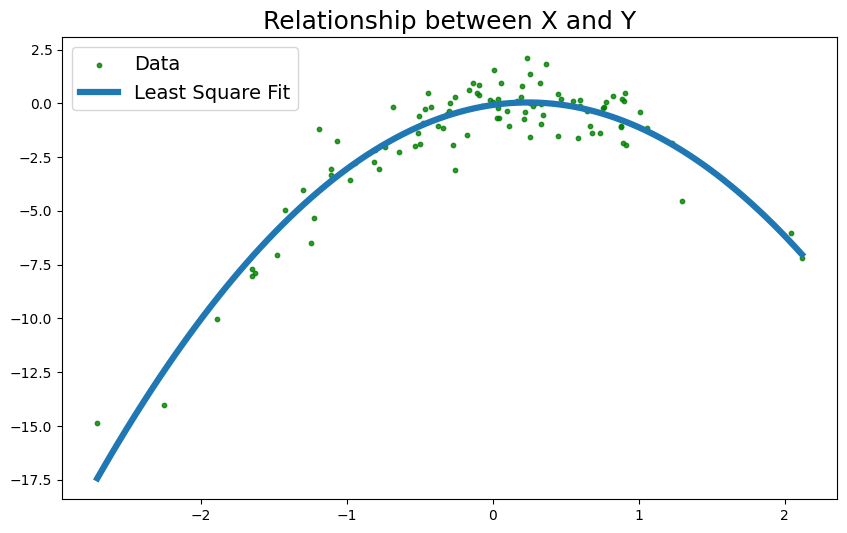

In [50]:
# Import seaborn package
import seaborn as sns

# Initialize figure
figsimu, axsimu = plt.subplots(1,1)
axsimu.set_title('Relationship between X and Y');

# Plot scatter and best fit line
sns.regplot(x=x, y=y, ax=axsimu, order=2, ci=None, scatter_kws={'color':'g', 's':10})
axsimu.legend(['Data','Least Square Fit']);

(c) Set a random seed, and then compute the LOOCV errors that
result from fitting the following four models using least squares:

i. $Y = \beta_0 + \beta_1X + \epsilon$

ii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$

iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$

iv. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$

Note you may find it helpful to use the data.frame() function
to create a single data set containing both X and Y .

In [51]:
# Import pandas
import pandas as pd

# Create dataframe
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,0.345584,-0.544554
1,0.821618,0.333950
2,0.330437,-0.013532
3,-1.303157,-4.030442
4,0.905356,0.484861
...,...,...
95,-2.250854,-14.001012
96,-0.138655,0.932532
97,0.033000,0.198928
98,-1.425349,-4.940183


In [52]:
#Create for loop to compute CV erros of 4 models with seed = 12345
cv_error = np.zeros(4)
Y, P = np.array(df['y']), np.array(df['x'])
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=100,
           shuffle=True,
           random_state=12345) 
for i, d in enumerate(range(1,5)):
    X = np.power.outer(P, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error


array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

In [53]:
#Create for loop to compute CV erros of 4 models with seed = 12345
cv = KFold(n_splits=100,
           shuffle=True,
           random_state=1) 
for i, d in enumerate(range(1,5)):
    X = np.power.outer(P, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

The results are identical with each of the two seeds because we are using LOOCV. They would be different if we were using K-fold CV because each seed would be associated with a different split of the data (ie: in LOOCV there is only one way to split the data in a number of groups equal to n, the number of observations in the dataframe).

(e) Which of the models in (c) had the smallest LOOCV error? Is
this what you expected? Explain your answer.

The model with the smallest LOOCV error is model ii. (the quadratic model). This is makes sense intuitively because the data were generated from a model with a quadratic functional form (i.e: a model with a linear term $X$ and a squared term $-2X^2$).

(f) Comment on the statistical significance of the coefficient estimates
that results from fitting each of the models in (c) using
least squares. Do these results agree with the conclusions drawn
based on the cross-validation results?

In [54]:
# Create an empty matrix of dimensions 4 x 5 (4 models x max number of parameters)
pval = np.full((4, 5), np.nan)

# Run loop for models estimated via OLS and replace elements of matrix coefs by p-values on coefficients in each model
for i, d in enumerate(range(1,5)):
    X = MS([poly('x', degree=d)]).fit_transform(df)
    model = sm.OLS(Y, X)
    results = model.fit()       
    values = np.round(results.pvalues, 5)
    pval[i, :len(values)] = values

pval

array([[0.     , 0.     ,     nan,     nan,     nan],
       [0.     , 0.     , 0.     ,     nan,     nan],
       [0.     , 0.     , 0.     , 0.2872 ,     nan],
       [0.     , 0.     , 0.     , 0.27668, 0.02311]])

The coefficients on the interecept, $X$ and $X^2$ are significant at the 1% level while the coefficient on $X^3$ is not significant and the coefficient on $X^4$ is only significant at the 5% level. The results are consistent with the LOOCV results.